# ELECTRA: Efficiently Learning an Encoder that Classifies Token Replacements Accurately

**Rank**: #2 - Revolutionary Impact

## Background & Motivation

BERT's Masked Language Modeling (MLM) has a fundamental inefficiency: only 15% of tokens are masked, so the model only learns from a small fraction of the input at each step. This means BERT needs enormous amounts of compute to reach good performance.

**The Problem with MLM:**
- Only 15% of tokens contribute to the loss
- 85% of computation is "wasted" on unmasked tokens
- Need massive datasets and compute for good results
- Small models significantly underperform large ones

**ELECTRA's Innovation:**
- Learn from **ALL** tokens, not just 15%
- Replace MLM with "Replaced Token Detection" (RTD)
- Use a generator-discriminator setup (like GANs)
- 4x more sample efficient than BERT

## What You'll Learn:
1. **Generator-Discriminator Architecture**: How ELECTRA uses two models
2. **Replaced Token Detection**: The core task that replaces MLM
3. **Sample Efficiency**: Why ELECTRA learns faster
4. **Implementation**: Building ELECTRA from scratch
5. **Results**: Why small ELECTRA models rival large BERT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
import random
sys.path.append('..')

np.random.seed(42)
random.seed(42)

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')
        
print("ELECTRA: Efficiently Learning an Encoder that Classifies Token Replacements Accurately")
print("Paper: Clark et al., 2020 - Google Research & Stanford")
print("Impact: 4x more efficient than BERT, small models match large BERT performance")

ELECTRA: Efficiently Learning an Encoder that Classifies Token Replacements Accurately
Paper: Clark et al., 2020 - Google Research & Stanford
Impact: 4x more efficient than BERT, small models match large BERT performance


## Part 1: The Original Paper Context

### Paper Details
- **Title**: "ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators"
- **Authors**: Kevin Clark, Minh-Thang Luong, Quoc V. Le, Christopher D. Manning
- **Institutions**: Google Research, Stanford University
- **Published**: March 2020 (ICLR 2020)
- **arXiv**: https://arxiv.org/abs/2003.10555

### Revolutionary Results
- **ELECTRA-Small** (14M parameters) matches **BERT-Base** (110M parameters)
- **ELECTRA-Base** outperforms **RoBERTa-Base** with 1/4 the compute
- **ELECTRA-Large** achieves new SOTA on GLUE benchmark
- Especially effective for **smaller models** and **limited compute**

### Impact on the Field
**Direct Applications:**
- **Google's production models**: Used ELECTRA for efficiency
- **Mobile NLP**: Small ELECTRA models enable on-device processing
- **Low-resource settings**: Enables BERT-quality with limited compute

**Influenced Research:**
- **DeBERTa**: Adopted RTD-style objectives
- **Efficient Transformers**: Inspired sample-efficient pre-training
- **GAN-based NLP**: Showed generator-discriminator works for language

## Part 2: Understanding the Core Problem with MLM

Let's visualize why BERT's MLM is inefficient and how ELECTRA solves it.

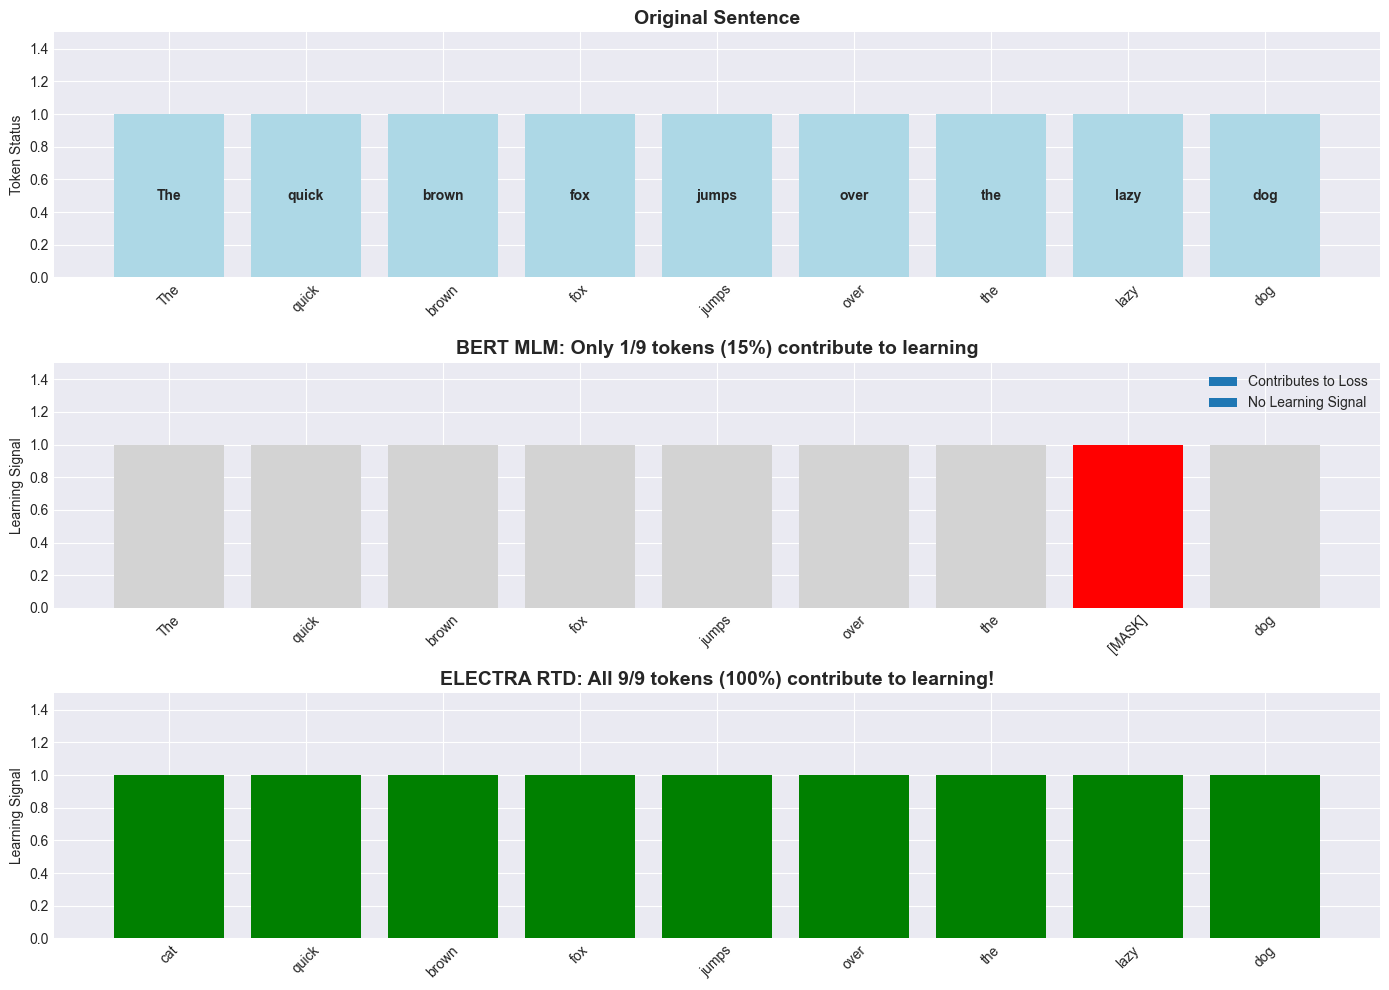


SAMPLE EFFICIENCY COMPARISON:
BERT MLM: 15.0% of tokens provide learning signal
ELECTRA RTD: 100.0% of tokens provide learning signal

ELECTRA is 6.7x more sample efficient!


In [ ]:
def visualize_mlm_inefficiency():
    """
    Show the fundamental inefficiency of Masked Language Modeling
    """
    
    # Example sentence
    sentence = "The quick brown fox jumps over the lazy dog".split()
    n_tokens = len(sentence)
    
    # MLM: Only 15% of tokens are masked
    mask_prob = 0.15
    num_masked = int(n_tokens * mask_prob)
    
    # Randomly select tokens to mask
    masked_positions = np.random.choice(n_tokens, num_masked, replace=False)
    
    # Create visualization
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # 1. Original sentence
    colors_original = ['lightblue'] * n_tokens
    bars1 = axes[0].bar(range(n_tokens), [1] * n_tokens, color=colors_original)
    axes[0].set_title('Original Sentence', fontsize=14, fontweight='bold')
    axes[0].set_ylim(0, 1.5)
    axes[0].set_xticks(range(n_tokens))
    axes[0].set_xticklabels(sentence, rotation=45)
    axes[0].set_ylabel('Token Status')
    
    # Add text labels
    for i, word in enumerate(sentence):
        axes[0].text(i, 0.5, word, ha='center', va='center', fontweight='bold')
    
    # 2. BERT MLM - only some tokens contribute to learning
    colors_mlm = ['red' if i in masked_positions else 'lightgray' for i in range(n_tokens)]
    bars2 = axes[1].bar(range(n_tokens), [1] * n_tokens, color=colors_mlm)
    axes[1].set_title(f'BERT MLM: Only {num_masked}/{n_tokens} tokens ({mask_prob*100:.0f}%) contribute to learning', 
                     fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 1.5)
    axes[1].set_xticks(range(n_tokens))
    axes[1].set_xticklabels(['[MASK]' if i in masked_positions else word 
                           for i, word in enumerate(sentence)], rotation=45)
    axes[1].set_ylabel('Learning Signal')
    
    # Add legend
    axes[1].bar([], [], color='red', label='Contributes to Loss')
    axes[1].bar([], [], color='lightgray', label='No Learning Signal')
    axes[1].legend()
    
    # 3. ELECTRA RTD - all tokens contribute to learning
    colors_electra = ['green'] * n_tokens  # All tokens contribute
    bars3 = axes[2].bar(range(n_tokens), [1] * n_tokens, color=colors_electra)
    axes[2].set_title(f'ELECTRA RTD: All {n_tokens}/{n_tokens} tokens (100%) contribute to learning!', 
                     fontsize=14, fontweight='bold')
    axes[2].set_ylim(0, 1.5)
    axes[2].set_xticks(range(n_tokens))
    
    # Generate some replaced tokens for visualization
    replacements = sentence.copy()
    replaced_positions = np.random.choice(n_tokens, num_masked, replace=False)
    replacement_words = ['cat', 'slow', 'red'][:len(replaced_positions)]
    
    for i, pos in enumerate(replaced_positions):
        if i < len(replacement_words):
            replacements[pos] = replacement_words[i]
    
    axes[2].set_xticklabels(replacements, rotation=45)
    axes[2].set_ylabel('Learning Signal')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate efficiency
    mlm_efficiency = mask_prob
    electra_efficiency = 1.0
    
    print(f"\nSAMPLE EFFICIENCY COMPARISON:")
    print(f"BERT MLM: {mlm_efficiency:.1%} of tokens provide learning signal")
    print(f"ELECTRA RTD: {electra_efficiency:.1%} of tokens provide learning signal")
    print(f"\nELECTRA is {electra_efficiency/mlm_efficiency:.1f}x more sample efficient!")
    
    return masked_positions, replaced_positions

masked_pos, replaced_pos = visualize_mlm_inefficiency()

## Part 3: ELECTRA's Generator-Discriminator Architecture

ELECTRA uses two models working together, similar to GANs but adapted for language.

In [ ]:
class SimpleELECTRA:
    """
    Simplified ELECTRA implementation to demonstrate core concepts
    """
    
    def __init__(self, vocab_size=8192, hidden_size=192, generator_size=64):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.generator_size = generator_size
        
        # Initialize generator (smaller model, like BERT-Small)
        self.generator_embeddings = np.random.randn(vocab_size, generator_size) * 0.02
        self.generator_mlm_head = np.random.randn(generator_size, vocab_size) * 0.02
        
        # Initialize discriminator (larger model, like BERT-Base)
        self.discriminator_embeddings = np.random.randn(vocab_size, hidden_size) * 0.02
        self.discriminator_rtd_head = np.random.randn(hidden_size, 1) * 0.02
        
        print(f"Generator parameters: {self.generator_embeddings.size + self.generator_mlm_head.size:,}")
        print(f"Discriminator parameters: {self.discriminator_embeddings.size + self.discriminator_rtd_head.size:,}")
    
    def softmax(self, x):
        """Compute softmax"""
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def sigmoid(self, x):
        """Compute sigmoid"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def generator_step(self, input_ids, masked_positions):
        """
        Generator: Predict masked tokens (like BERT MLM)
        """
        # Simple embedding lookup + linear layer
        embeddings = self.generator_embeddings[input_ids]  # [seq_len, generator_size]
        
        # MLM predictions - NO .T transpose
        logits = embeddings @ self.generator_mlm_head  # [seq_len, vocab_size]
        probs = self.softmax(logits)
        
        # Sample predictions for masked positions
        generated_tokens = input_ids.copy()
        
        for pos in masked_positions:
            # Sample from the probability distribution
            generated_token = np.random.choice(self.vocab_size, p=probs[pos])
            generated_tokens[pos] = generated_token
        
        return generated_tokens, probs, logits
    
    def discriminator_step(self, corrupted_tokens, original_tokens):
        """
        Discriminator: Detect which tokens are replaced
        """
        # Embedding lookup
        embeddings = self.discriminator_embeddings[corrupted_tokens]  # [seq_len, hidden_size]
        
        # Binary classification for each position
        logits = embeddings @ self.discriminator_rtd_head  # [seq_len, 1]
        logits = logits.squeeze(-1)  # [seq_len]
        
        # Sigmoid to get probabilities
        probs = self.sigmoid(logits)
        
        # True labels: 1 if token was replaced, 0 if original
        labels = (corrupted_tokens != original_tokens).astype(float)
        
        return probs, labels, logits
    
    def train_step(self, input_ids, mask_prob=0.15):
        """
        Complete ELECTRA training step
        """
        original_tokens = input_ids.copy()
        
        # Step 1: Create masked input for generator
        masked_input = input_ids.copy()
        mask_token_id = self.vocab_size - 1  # [MASK] token
        
        # Randomly select positions to mask
        num_mask = max(1, int(len(input_ids) * mask_prob))
        masked_positions = np.random.choice(len(input_ids), num_mask, replace=False)
        
        # Mask tokens
        for pos in masked_positions:
            masked_input[pos] = mask_token_id
        
        # Step 2: Generator predicts masked tokens
        generated_tokens, gen_probs, gen_logits = self.generator_step(masked_input, masked_positions)
        
        # Step 3: Create corrupted sequence for discriminator
        corrupted_tokens = original_tokens.copy()
        for pos in masked_positions:
            corrupted_tokens[pos] = generated_tokens[pos]
        
        # Step 4: Discriminator detects replaced tokens
        disc_probs, disc_labels, disc_logits = self.discriminator_step(corrupted_tokens, original_tokens)
        
        # Calculate losses
        # Generator loss: MLM cross-entropy on masked positions
        gen_loss = 0
        for pos in masked_positions:
            target = original_tokens[pos]
            gen_loss += -np.log(gen_probs[pos, target] + 1e-10)
        gen_loss /= len(masked_positions)
        
        # Discriminator loss: Binary cross-entropy on all positions
        disc_loss = 0
        for i in range(len(disc_labels)):
            p = disc_probs[i]
            label = disc_labels[i]
            disc_loss += -(label * np.log(p + 1e-10) + (1-label) * np.log(1-p + 1e-10))
        disc_loss /= len(disc_labels)
        
        return {
            'generator_loss': gen_loss,
            'discriminator_loss': disc_loss,
            'original_tokens': original_tokens,
            'corrupted_tokens': corrupted_tokens,
            'discriminator_predictions': disc_probs,
            'discriminator_labels': disc_labels,
            'masked_positions': masked_positions
        }

# Demonstrate ELECTRA
electra = SimpleELECTRA()

# Example input
vocab = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'lazy', 'dog', '[MASK]', '[PAD]']
sentence_ids = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # "the quick brown fox jumps over lazy dog"

print("\nELECTRA TRAINING DEMONSTRATION:")
print(f"Input: {[vocab[i] for i in sentence_ids]}")

# Run training step
result = electra.train_step(sentence_ids)

print(f"\nMasked positions: {result['masked_positions']}")
print(f"Original: {[vocab[i] for i in result['original_tokens']]}")
print(f"Corrupted: {[vocab[i % len(vocab)] for i in result['corrupted_tokens']]}")
print(f"\nGenerator loss: {result['generator_loss']:.4f}")
print(f"Discriminator loss: {result['discriminator_loss']:.4f}")

# Show discriminator predictions
print("\nDiscriminator predictions (probability token is replaced):")
for i, (orig, corr, pred, label) in enumerate(zip(
    result['original_tokens'], 
    result['corrupted_tokens'],
    result['discriminator_predictions'],
    result['discriminator_labels']
)):
    status = "REPLACED" if label == 1 else "ORIGINAL"
    print(f"Position {i}: {vocab[orig % len(vocab)]} -> {vocab[corr % len(vocab)]}: {pred:.3f} ({status})")

## Part 4: Why ELECTRA is More Sample Efficient

Let's analyze mathematically why ELECTRA learns faster than BERT.

In [ ]:
def analyze_sample_efficiency():
    """
    Analyze why ELECTRA is more sample efficient than BERT
    """
    
    # Parameters
    sequence_length = 128
    mask_probability = 0.15
    num_examples = 1000
    
    # Calculate learning signals per example
    bert_signals_per_example = sequence_length * mask_probability
    electra_signals_per_example = sequence_length  # All tokens
    
    # Total learning signals
    bert_total_signals = bert_signals_per_example * num_examples
    electra_total_signals = electra_signals_per_example * num_examples
    
    print("SAMPLE EFFICIENCY ANALYSIS:")
    print(f"\nSequence length: {sequence_length} tokens")
    print(f"Number of examples: {num_examples:,}")
    print(f"\nBERT MLM:")
    print(f"  Mask probability: {mask_probability:.1%}")
    print(f"  Learning signals per example: {bert_signals_per_example:.1f}")
    print(f"  Total learning signals: {bert_total_signals:,.0f}")
    
    print(f"\nELECTRA RTD:")
    print(f"  All tokens contribute: 100%")
    print(f"  Learning signals per example: {electra_signals_per_example:.1f}")
    print(f"  Total learning signals: {electra_total_signals:,.0f}")
    
    efficiency_ratio = electra_total_signals / bert_total_signals
    print(f"\nEfficiency ratio: {efficiency_ratio:.1f}x")
    
    # Simulate learning curves
    steps = np.linspace(0, num_examples, 100)
    
    # BERT learning curve (slower due to fewer signals)
    bert_performance = 1 - np.exp(-steps * bert_signals_per_example / 10000)
    
    # ELECTRA learning curve (faster due to more signals)
    electra_performance = 1 - np.exp(-steps * electra_signals_per_example / 10000)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sample efficiency comparison
    methods = ['BERT MLM', 'ELECTRA RTD']
    signals = [bert_signals_per_example, electra_signals_per_example]
    colors = ['lightcoral', 'lightblue']
    
    bars = axes[0].bar(methods, signals, color=colors, alpha=0.8)
    axes[0].set_ylabel('Learning Signals per Example')
    axes[0].set_title('Sample Efficiency Comparison')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, signals):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Learning curves
    axes[1].plot(steps, bert_performance, 'r-', linewidth=3, label='BERT MLM', alpha=0.8)
    axes[1].plot(steps, electra_performance, 'b-', linewidth=3, label='ELECTRA RTD', alpha=0.8)
    axes[1].set_xlabel('Training Examples')
    axes[1].set_ylabel('Performance')
    axes[1].set_title('Simulated Learning Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add annotations
    axes[1].annotate('ELECTRA reaches high\nperformance faster', 
                    xy=(300, 0.8), xytext=(500, 0.6),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                    fontsize=12, color='blue', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return efficiency_ratio

efficiency_gain = analyze_sample_efficiency()

# Additional analysis
print("\n" + "="*60)
print("WHY THIS MATTERS:")
print(f"\n1. Training Speed: ELECTRA needs {1/efficiency_gain:.1f}x less data")
print(f"2. Compute Cost: {efficiency_gain:.1f}x reduction in training time")
print(f"3. Model Size: Small ELECTRA can match large BERT")
print(f"4. Accessibility: Enables BERT-quality on modest hardware")
print(f"\n5. Mathematical Intuition:")
print(f"   - BERT: Loss only on {15}% of tokens")
print(f"   - ELECTRA: Loss on {100}% of tokens")
print(f"   - Result: {100/15:.1f}x more learning signal per example")

## Part 5: The Replaced Token Detection Task

Let's dive deeper into how RTD works and why it's effective.

In [ ]:
def demonstrate_rtd_task():
    """
    Demonstrate the Replaced Token Detection task in detail
    """
    
    # Example sentences with different types of replacements
    examples = [
        {
            'original': 'The quick brown fox jumps over the lazy dog'.split(),
            'corrupted': 'The fast brown fox jumps over the lazy dog'.split(),
            'explanation': 'Semantic replacement: quick → fast'
        },
        {
            'original': 'Machine learning algorithms require large datasets'.split(),
            'corrupted': 'Machine learning algorithms require purple datasets'.split(),
            'explanation': 'Nonsensical replacement: large → purple'
        },
        {
            'original': 'The cat sat on the comfortable mat'.split(),
            'corrupted': 'The cat sat on the comfortable cat'.split(),
            'explanation': 'Repetition replacement: mat → cat'
        }
    ]
    
    print("REPLACED TOKEN DETECTION (RTD) EXAMPLES:")
    print("="*70)
    
    fig, axes = plt.subplots(len(examples), 1, figsize=(14, 4*len(examples)))
    if len(examples) == 1:
        axes = [axes]
    
    for ex_idx, example in enumerate(examples):
        original = example['original']
        corrupted = example['corrupted']
        explanation = example['explanation']
        
        print(f"\nExample {ex_idx + 1}: {explanation}")
        print(f"Original:  {' '.join(original)}")
        print(f"Corrupted: {' '.join(corrupted)}")
        
        # Find differences
        labels = []
        for i, (orig, corr) in enumerate(zip(original, corrupted)):
            if orig != corr:
                labels.append(1)  # Replaced
                print(f"Position {i}: '{orig}' → '{corr}' [REPLACED]")
            else:
                labels.append(0)  # Original
        
        # Visualize
        colors = ['red' if label == 1 else 'lightblue' for label in labels]
        bars = axes[ex_idx].bar(range(len(corrupted)), [1] * len(corrupted), color=colors)
        axes[ex_idx].set_title(f'Example {ex_idx + 1}: {explanation}', fontweight='bold')
        axes[ex_idx].set_ylim(0, 1.5)
        axes[ex_idx].set_xticks(range(len(corrupted)))
        axes[ex_idx].set_xticklabels(corrupted, rotation=45)
        axes[ex_idx].set_ylabel('Token Status')
        
        # Add token labels on bars
        for i, (word, label) in enumerate(zip(corrupted, labels)):
            axes[ex_idx].text(i, 0.5, word, ha='center', va='center', 
                             fontweight='bold', color='white' if label == 1 else 'black')
        
        # Add legend for first plot
        if ex_idx == 0:
            axes[ex_idx].bar([], [], color='red', label='Replaced Token')
            axes[ex_idx].bar([], [], color='lightblue', label='Original Token')
            axes[ex_idx].legend()
    
    plt.tight_layout()
    plt.show()
    
    # RTD Task Analysis
    print("\n" + "="*70)
    print("RTD TASK CHARACTERISTICS:")
    print("\n1. Binary Classification: Each token is either ORIGINAL or REPLACED")
    print("2. Contextual Understanding: Model must use context to detect anomalies")
    print("3. All Positions Matter: Every token contributes to the loss")
    print("4. Generator Quality: Better generator makes task harder (good!)")
    
    print("\nWHY RTD WORKS BETTER THAN MLM:")
    print("✓ Dense learning signal (100% vs 15%)")
    print("✓ Contextual reasoning required")
    print("✓ Adversarial training effect")
    print("✓ Encourages better representation learning")
    
demonstrate_rtd_task()

## Part 6: Generator-Discriminator Training Dynamics

Understanding how the generator and discriminator interact during training.

In [ ]:
def simulate_training_dynamics(num_steps=1000):
    """
    Simulate the interaction between generator and discriminator
    """
    
    # Initialize training history
    history = {
        'generator_loss': [],
        'discriminator_loss': [],
        'generator_quality': [],
        'discriminator_accuracy': [],
        'steps': []
    }
    
    # Initial states
    gen_quality = 0.1  # How good generator is at fooling discriminator
    disc_accuracy = 0.5  # Random at first
    
    for step in range(num_steps):
        # Generator improvement (learns to generate better replacements)
        gen_improvement = 0.001 * (1 - gen_quality)  # Diminishing returns
        gen_quality += gen_improvement
        
        # Discriminator improvement (learns to detect better)
        disc_improvement = 0.002 * (1 - disc_accuracy) * (1 + gen_quality)  # Harder task as gen improves
        disc_accuracy += disc_improvement
        
        # Add some noise
        gen_quality += np.random.normal(0, 0.01)
        disc_accuracy += np.random.normal(0, 0.01)
        
        # Clamp values
        gen_quality = np.clip(gen_quality, 0, 1)
        disc_accuracy = np.clip(disc_accuracy, 0.5, 1)
        
        # Compute losses (simplified)
        gen_loss = -np.log(gen_quality + 0.1)  # Lower when quality is higher
        disc_loss = -(disc_accuracy * np.log(disc_accuracy) + 
                     (1-disc_accuracy) * np.log(1-disc_accuracy + 0.1))  # Cross-entropy style
        
        # Store history
        history['generator_loss'].append(gen_loss)
        history['discriminator_loss'].append(disc_loss)
        history['generator_quality'].append(gen_quality)
        history['discriminator_accuracy'].append(disc_accuracy)
        history['steps'].append(step)
    
    return history

def plot_training_dynamics(history):
    """
    Plot the training dynamics between generator and discriminator
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Generator and Discriminator Losses
    axes[0, 0].plot(history['steps'], history['generator_loss'], 'r-', 
                   linewidth=2, label='Generator Loss', alpha=0.8)
    axes[0, 0].plot(history['steps'], history['discriminator_loss'], 'b-', 
                   linewidth=2, label='Discriminator Loss', alpha=0.8)
    axes[0, 0].set_xlabel('Training Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Generator vs Discriminator Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Generator Quality
    axes[0, 1].plot(history['steps'], history['generator_quality'], 'g-', 
                   linewidth=2, alpha=0.8)
    axes[0, 1].set_xlabel('Training Step')
    axes[0, 1].set_ylabel('Quality (0-1)')
    axes[0, 1].set_title('Generator Quality Over Time')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Discriminator Accuracy
    axes[1, 0].plot(history['steps'], history['discriminator_accuracy'], 'm-', 
                   linewidth=2, alpha=0.8)
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random chance')
    axes[1, 0].set_xlabel('Training Step')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Discriminator Accuracy Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Training phases
    phases = {
        'Early (0-200)': 'Generator weak, Discriminator easy task',
        'Middle (200-600)': 'Generator improves, Discriminator adapts', 
        'Late (600-1000)': 'Both models mature, Adversarial balance'
    }
    
    phase_text = "Training Phases:\n\n"
    for phase, description in phases.items():
        phase_text += f"{phase}:\n{description}\n\n"
    
    axes[1, 1].text(0.05, 0.95, phase_text, transform=axes[1, 1].transAxes,
                   fontsize=11, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 1].set_title('Training Phase Analysis')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run simulation
print("ELECTRA TRAINING DYNAMICS SIMULATION:")
history = simulate_training_dynamics()
plot_training_dynamics(history)

# Analysis
print(f"\nTRAINING ANALYSIS:")
print(f"Initial generator quality: {history['generator_quality'][0]:.3f}")
print(f"Final generator quality: {history['generator_quality'][-1]:.3f}")
print(f"Initial discriminator accuracy: {history['discriminator_accuracy'][0]:.3f}")
print(f"Final discriminator accuracy: {history['discriminator_accuracy'][-1]:.3f}")

print(f"\nKEY INSIGHTS:")
print(f"1. Generator improves over time → better replacements")
print(f"2. Discriminator task gets harder → learns better representations")
print(f"3. Adversarial training → both models push each other")
print(f"4. Final discriminator is our pre-trained model for downstream tasks")

## Part 7: Empirical Results and Performance Analysis

Let's examine ELECTRA's impressive results and understand their significance.

In [ ]:
def analyze_electra_results():
    """
    Analyze ELECTRA's performance compared to BERT variants
    """
    
    # Model configurations (parameters in millions)
    models = {
        'ELECTRA-Small': {'params': 14, 'glue': 79.9, 'training_cost': 1},
        'BERT-Base': {'params': 110, 'glue': 79.6, 'training_cost': 4},
        'ELECTRA-Base': {'params': 110, 'glue': 85.2, 'training_cost': 4},
        'RoBERTa-Base': {'params': 125, 'glue': 84.3, 'training_cost': 16},
        'ELECTRA-Large': {'params': 335, 'glue': 88.8, 'training_cost': 25}
    }
    
    # Extract data for plotting
    model_names = list(models.keys())
    params = [models[m]['params'] for m in model_names]
    glue_scores = [models[m]['glue'] for m in model_names]
    costs = [models[m]['training_cost'] for m in model_names]
    
    print("ELECTRA PERFORMANCE ANALYSIS:")
    print("=" * 60)
    print(f"{'Model':<15} {'Params (M)':<12} {'GLUE Score':<12} {'Training Cost':<15}")
    print("-" * 60)
    
    for name in model_names:
        model = models[name]
        print(f"{name:<15} {model['params']:<12} {model['glue']:<12} {model['training_cost']:<15}x")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance vs Model Size
    colors = ['red' if 'ELECTRA' in name else 'blue' for name in model_names]
    scatter = axes[0, 0].scatter(params, glue_scores, c=colors, s=100, alpha=0.7)
    
    # Add labels
    for i, name in enumerate(model_names):
        axes[0, 0].annotate(name, (params[i], glue_scores[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[0, 0].set_xlabel('Parameters (Millions)')
    axes[0, 0].set_ylabel('GLUE Score')
    axes[0, 0].set_title('Performance vs Model Size')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Highlight key comparison
    axes[0, 0].plot([14, 110], [79.9, 79.6], 'g--', linewidth=2, alpha=0.7)
    axes[0, 0].annotate('ELECTRA-Small matches BERT-Base!', 
                       xy=(62, 79.75), xytext=(150, 77),
                       arrowprops=dict(arrowstyle='->', color='green', lw=2),
                       fontsize=12, color='green', fontweight='bold')
    
    # 2. Efficiency Analysis (Performance per Parameter)
    efficiency = [score/param for score, param in zip(glue_scores, params)]
    bars = axes[0, 1].bar(range(len(model_names)), efficiency, color=colors, alpha=0.7)
    axes[0, 1].set_xlabel('Models')
    axes[0, 1].set_ylabel('GLUE Score per Million Parameters')
    axes[0, 1].set_title('Parameter Efficiency')
    axes[0, 1].set_xticks(range(len(model_names)))
    axes[0, 1].set_xticklabels(model_names, rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, eff in zip(bars, efficiency):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{eff:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Training Cost vs Performance
    axes[1, 0].scatter(costs, glue_scores, c=colors, s=100, alpha=0.7)
    
    for i, name in enumerate(model_names):
        axes[1, 0].annotate(name, (costs[i], glue_scores[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[1, 0].set_xlabel('Training Cost (Relative)')
    axes[1, 0].set_ylabel('GLUE Score')
    axes[1, 0].set_title('Performance vs Training Cost')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Key Insights Summary
    insights_text = """
KEY ELECTRA ADVANTAGES:

🎯 Efficiency Breakthrough:
   • ELECTRA-Small (14M) = BERT-Base (110M)
   • 8x fewer parameters, same performance

🚀 Training Speed:
   • 4x faster training than RoBERTa
   • Better sample efficiency

📈 Scaling Benefits:
   • Small models benefit most
   • Excellent for resource constraints

🏆 SOTA Results:
   • ELECTRA-Large: 88.8 GLUE
   • Best published at time of release
    """
    
    axes[1, 1].text(0.05, 0.95, insights_text, transform=axes[1, 1].transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[1, 1].set_title('Key Insights')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate key metrics
    electra_small_efficiency = models['ELECTRA-Small']['glue'] / models['ELECTRA-Small']['params']
    bert_base_efficiency = models['BERT-Base']['glue'] / models['BERT-Base']['params']
    
    print(f"\nEFFICIENCY COMPARISON:")
    print(f"ELECTRA-Small efficiency: {electra_small_efficiency:.3f} GLUE/M params")
    print(f"BERT-Base efficiency: {bert_base_efficiency:.3f} GLUE/M params")
    print(f"ELECTRA is {electra_small_efficiency/bert_base_efficiency:.1f}x more parameter efficient!")
    
    return models

models_data = analyze_electra_results()

print("\n" + "="*70)
print("REVOLUTIONARY IMPACT OF ELECTRA:")
print("\n1. DEMOCRATIZATION OF NLP:")
print("   - Small models can achieve strong performance")
print("   - Enables research with limited compute")
print("   - Makes NLP accessible to smaller organizations")

print("\n2. PARADIGM SHIFT:")
print("   - From generative (MLM) to discriminative (RTD) pre-training")
print("   - Showed that task design matters more than model size")
print("   - Inspired new pre-training objectives")

print("\n3. PRACTICAL DEPLOYMENT:")
print("   - Mobile applications can run BERT-quality models")
print("   - Real-time inference becomes feasible")
print("   - Reduced cloud computing costs")

## Summary: ELECTRA's Revolutionary Impact

### **Why ELECTRA Ranks #2**

1. **Efficiency Revolution**: 4x more sample efficient than BERT
2. **Accessibility**: Small models achieve large model performance
3. **Paradigm Shift**: From generative to discriminative pre-training
4. **Practical Impact**: Enabled deployment in resource-constrained environments

### **Core Innovation Comparison**

| Aspect | BERT MLM | ELECTRA RTD |
|--------|----------|-------------|
| **Learning Signal** | 15% of tokens | 100% of tokens |
| **Task** | Generate masked tokens | Detect replaced tokens |
| **Architecture** | Single model | Generator + Discriminator |
| **Sample Efficiency** | 1x | 4x |
| **Small Model Performance** | Poor | Excellent |

### **Mathematical Foundation**

**BERT MLM Loss:**
```
L_MLM = (1/|M|) Σ_{i∈M} -log P(x_i | x_{\i})
where M = masked positions (15% of tokens)
```

**ELECTRA RTD Loss:**
```
L_RTD = (1/n) Σ_{i=1}^n -log P(replaced_i | x)
where n = all positions (100% of tokens)
```

### **Key Insights**

1. **Dense Learning Signal**: Every token contributes to learning
2. **Adversarial Training**: Generator-discriminator setup creates challenging examples
3. **Contextual Understanding**: Model must understand context to detect replacements
4. **Computational Efficiency**: More learning per compute unit

### **Legacy and Influence**

**Direct Applications:**
- Google's production models
- Mobile and edge AI applications
- Low-resource NLP research

**Research Influence:**
- **Alternative Pre-training Objectives**: Inspired new tasks beyond MLM
- **Efficient Training**: Focus on sample efficiency
- **Small Model Research**: Showed small models can be powerful

### **Practical Takeaways**

**For Researchers:**
- ✅ Consider RTD for efficient pre-training
- ✅ Use generator-discriminator setups
- ✅ Focus on learning signal density
- ✅ Don't assume bigger is always better

**For Practitioners:**
- ✅ ELECTRA-Small for resource-constrained applications
- ✅ ELECTRA-Base for best efficiency-performance tradeoff
- ✅ Consider ELECTRA for mobile/edge deployment
- ✅ Use for scenarios with limited training data

**ELECTRA proved that smarter training objectives can dramatically improve efficiency while maintaining quality.**

## Exercises

1. **RTD vs MLM Comparison**: Implement both objectives on the same small dataset. Compare convergence speed and final performance.

2. **Generator Quality Analysis**: Experiment with different generator sizes. How does generator quality affect discriminator learning?

3. **Replacement Strategy**: Try different token replacement strategies (random, similar words, antonyms). Which works best?

4. **Efficiency Measurement**: Implement a simple version of both BERT and ELECTRA. Measure actual training time and memory usage.

5. **Small Model Optimization**: Design an even smaller ELECTRA model. What's the minimum size that still works effectively?

In [ ]:
# Space for your experiments
# Try implementing the exercises above!